In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
    KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix

%config InlineBackend.figure_format = 'png'
%matplotlib inline
sns.set(color_codes=True)
plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

## Data Loading ##

In [182]:
with open('feature_engineering_sample_df.pickle', 'wb') as to_write:
    pickle.dump(sample_df, to_write)

In [183]:
with open('cv_records.pickle', 'wb') as to_write:
    pickle.dump(cv_records, to_write)

In [2]:
with open('cleaned_sample_df.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [6]:
with open('cv_records.pickle', 'rb') as read_file:
    cv_records = pickle.load(read_file)

In [7]:
cv_records

[{'model': 'logistic',
  'iteration_desc': 'baseline',
  'feature_engineering': '',
  'hyperparameter_tuning': '',
  'mean_train_f1': 0.0,
  'mean_val_f1': 0.0,
  'mean_train_precision': 0.0,
  'mean_val_precision': 0.0,
  'mean_train_recall': 0.0,
  'mean_val_recall': 0.0,
  'mean_train_accuracy': 0.8326874999999999,
  'mean_val_accuracy': 0.8326875000000001}]

In [4]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0
1,2015,6,21,7,WN,511,N7714B,DEN,CMH,1835,1831,-4.0,11.0,1842,165,157.0,140.0,1154,2302,6.0,2320,2308,-12.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,Denver International Airport,Denver,CO,39.86,-104.67,Port Columbus International Airport,Columbus,OH,40.00,-82.89,0
2,2015,2,18,3,AA,1271,N3ESAA,SNA,DFW,1217,1210,-7.0,12.0,1222,168,168.0,139.0,1205,1641,17.0,1705,1658,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,John Wayne Airport (Orange County Airport),Santa Ana,CA,33.68,-117.87,Dallas/Fort Worth International Airport,Dallas-Fort Worth,TX,32.90,-97.04,0
3,2015,8,26,3,DL,1925,N963DN,ATL,BWI,0730,0729,-1.0,16.0,0745,110,104.0,81.0,577,0906,7.0,0920,0913,-7.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Delta Air Lines Inc.,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,Baltimore-Washington International Airport,Baltimore,MD,39.18,-76.67,0
4,2015,6,1,1,WN,3301,N793SA,SAT,DAL,1250,1244,-6.0,11.0,1255,60,64.0,48.0,248,1343,5.0,1350,1348,-2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Southwest Airlines Co.,San Antonio International Airport,San Antonio,TX,29.53,-98.47,Dallas Love Field,Dallas,TX,32.85,-96.85,0


In [5]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   year                           100000 non-null  int64  
 1   month                          100000 non-null  int64  
 2   day                            100000 non-null  int64  
 3   day_of_week                    100000 non-null  int64  
 4   airline                        100000 non-null  object 
 5   flight_number                  100000 non-null  int64  
 6   tail_number                    99757 non-null   object 
 7   origin_airport                 100000 non-null  object 
 8   destination_airport            100000 non-null  object 
 9   scheduled_departure            100000 non-null  object 
 10  departure_time                 98518 non-null   object 
 11  departure_delay                98518 non-null   float64
 12  taxi_out                       

## Functions ##

In [8]:
def initial_split(X, y):
    """Splits features and target dataframes in 80/20 ratio.

    Args:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting of the target.

    Returns:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        X_test: A dataframe, containing 20% of the original features data, to be
            used for testing.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        y_test: A dataframe, containing 20% of the original target data, to be
            used for testing.
    """
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=4444)
    return X_train_val, X_test, y_train_val, y_test

In [9]:
def second_split(X_train_val, y_train_val):
    """Splits features and target dataframes so training set
    is 60% of all data and validation set is 20% of all data.

    Args:
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation. 
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
    """
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=.25, random_state=4444)
    return X_train, X_val, y_train, y_val

In [10]:
def feature_target_selection(features, target, df):
    """Returns two dataframes, each corresponding to the features and target.

    Args:
        features: A list of features for the model.
        target: The target for the model, passed as a single-element list.

    Returns:
        X: A dataframe only consisting of the features.
        y: A dataframe only consisting ot the target.
    """
    X = df.loc[:, features]
    y = df[target]
    return X, y

In [135]:
def cv(model, X_train_val, y_train_val, cv_records):
    """Performs 5-fold cross validation and prints training and test scores.
    Also adds scores to cv_records, which is a list of dicts.

    Args:
        model: Model to perform cross validation on. 
        X_train_val: A dataframe, containing 80% of the original features data,
            to be used for training and validation.
        y_train_val: A dataframe, containing 80% of the original target data, to
            be used for training and validation.
        cv_records: A list of dicts to record cross validation scores.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=4444)
    scores = cross_validate(model, X_train_val, y_train_val,
                            cv=kf, scoring=['f1', 'precision',
                                            'recall', 'accuracy',
                                            'roc_auc'],
                            return_train_score=True)
    
    model_name = re.sub(r'\((.*)\)', '', str(model))
    hyperparameters = str(model).replace(model_name, '')[1:-1]
    mean_train_f1 = np.mean(scores['train_f1'])
    mean_val_f1 = np.mean(scores['test_f1'])
    mean_train_precision = np.mean(scores['train_precision'])
    mean_val_precision = np.mean(scores['test_precision'])
    mean_train_recall = np.mean(scores['train_recall'])
    mean_val_recall = np.mean(scores['test_recall'])
    mean_train_accuracy = np.mean(scores['train_accuracy'])
    mean_val_accuracy = np.mean(scores['test_accuracy'])
    mean_train_auc = np.mean(scores['train_roc_auc'])
    mean_val_auc = np.mean(scores['test_roc_auc'])

    print(f'Model name: {model_name}')
    print(f'Hyperparameters: {hyperparameters}\n')
    
    print(f'{"Mean train F1:": <25} {mean_train_f1: .2f}')
    print(f'{"Mean val F1:": <25} {mean_val_f1: .2f}')
    print(f'{"Mean train precision:": <25} {mean_train_precision: .2f}')
    print(f'{"Mean val precision:": <25} {mean_val_precision: .2f}')
    print(f'{"Mean train recall:": <25} {mean_train_recall: .2f}')
    print(f'{"Mean val recall:": <25} {mean_val_recall: .2f}')
    print(f'{"Mean train accuracy:": <25} {mean_train_accuracy: .2f}')
    print(f'{"Mean val accuracy:": <25} {mean_val_accuracy: .2f}')
    print(f'{"Mean train AUC:": <25} {mean_train_auc: .2f}')
    print(f'{"Mean val AUC:": <25} {mean_val_auc: .2f}')

    cv_records.append(record_cv(model_name, hyperparameters,
                                mean_train_f1, mean_val_f1,
                                mean_train_precision, mean_val_precision,
                                mean_train_recall, mean_val_recall,
                                mean_train_accuracy, mean_val_accuracy,
                                mean_train_auc, mean_val_auc))

In [141]:
def record_cv(model_name, hyperparameters, 
              mean_train_f1, mean_val_f1,
              mean_train_precision, mean_val_precision,
              mean_train_recall, mean_val_recall,
              mean_train_accuracy, mean_val_accuracy,
              mean_train_auc, mean_val_auc):
    """Records cross validation scores with other record-keeping information
    in a dict.

    Args:
        model_name: The model's name.
        hyperparameters: The model's hyperparameters. 
        mean_train_f1: The mean cross validation training F1 score.
        mean_val_f1: The mean cross validation validation F1 score.
        mean_train_precision: The mean cross validation training precision score.
        mean_val_precision: The mean cross validation validation precision score.
        mean_train_recall: The mean cross validation training recall score.
        mean_val_recall: The mean cross validation validation recall score.
        mean_train_accuracy: The mean cross validation training accuracy score.
        mean_val_accuracy: The mean cross validation validation accuracy score.
        mean_train_auc: The mean cross validation training AUC score.
        mean_val_auc: The mean cross validation validation AUC score.

    Returns:
        cv_dict: A dict of cross valiation scores with other record-keeping
            information.
    """
    cv_dict = {}
    desc = input("iteration_desc: ")
    feature_eng = input("feature_engineering: ")

    cv_dict['model'] = model_name
    cv_dict['iteration_desc'] = desc
    cv_dict['feature_engineering'] = feature_eng
    cv_dict['hyperparameter_tuning'] = hyperparameters

    cv_dict['mean_train_f1'] = float(f'{mean_train_f1: .2f}')
    cv_dict['mean_val_f1'] = float(f'{mean_val_f1: .2f}')
    cv_dict['mean_train_precision'] = float(f'{mean_train_precision: .2f}')
    cv_dict['mean_val_precision'] = float(f'{mean_val_precision: .2f}')
    cv_dict['mean_train_recall'] = float(f'{mean_train_recall: .2f}')
    cv_dict['mean_val_recall'] = float(f'{mean_val_recall: .2f}')
    cv_dict['mean_train_accuracy'] = float(f'{mean_train_accuracy: .2f}')
    cv_dict['mean_val_accuracy'] = float(f'{mean_val_accuracy: .2f}')
    cv_dict['mean_train_AUC'] = float(f'{mean_train_auc: .2f}')
    cv_dict['mean_val_AUC'] = float(f'{mean_val_auc: .2f}')

    return cv_dict

In [13]:
def plot_ROC(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    model_name = re.sub(r'\((.*)\)', '', str(model))
    plt.plot(fpr, tpr, lw=2, label=model_name)
    plt.plot([0, 1], [0, 1], c='violet', ls='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
    plt.title('ROC curves')
    plt.legend()
    return fpr, tpr, thresholds

In [14]:
def get_best_threshold_from_roc_curve(fpr, tpr, thresholds):
    """Returns best combined tpr/fpr score and the threshold associated with that score.

    Args:
        fpr: False positive rates (fp/(fp+tn)).
        tpr: True positive rates (tp/tp+fn).

    Returns:
        best_score: Highest combined tpr/fpr score (tpr - fpr).
        best_threshold: Threshold that corresponds to best_score.
        """
    combined_score = tpr - fpr
    best_threshold = thresholds[np.argmax(combined_score)]
    best_score = np.amax(combined_score)
    return best_score, best_threshold

In [15]:
def pairplot_features(df):
    """Displays pairplot for given set of features with distributions
    differentiated by the target class is_not_on_time.

    Args: 
        df: Dataframe with desired features and target.    
    """
    sample = df.sample(10000, random_state=4444)
    sns.pairplot(sample, hue='is_not_on_time', plot_kws=dict(alpha=0.3))

## Feature Engineering ##

In [38]:
sample_df.shape[0]

100000

In [37]:
sample_df.groupby(['airline_name'], as_index=False).size().sum()

100000

In [42]:
# Step 1
airline_features = ['airline_avg_delay',
                    'airline_total_diversions',
                    'airline_total_cancellations',
                    'airline_total_flights']


airline_features_df = (sample_df.groupby(['airline_name'], as_index=False)
                       .agg({'arrival_delay': 'mean',
                             'diverted': 'sum',
                             'cancelled': 'sum',
                             'flight_number': 'count'}))

airline_features_df.columns = ['airline_name'] + airline_features

airline_features_df['airline_percent_diversions_cancellations'] = ((airline_features_df['airline_total_diversions']
                                                                    + airline_features_df['airline_total_cancellations'])
                                                                   / airline_features_df['airline_total_flights']
                                                                   * 100)

airline_features_df

,airline_name,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations
0,Alaska Airlines Inc.,0.33,7,13,2973,0.67
1,American Airlines Inc.,6.64,46,185,12662,1.82
2,American Eagle Airlines Inc.,15.35,12,249,4986,5.23
3,Atlantic Southeast Airlines,11.72,46,254,9877,3.04
4,Delta Air Lines Inc.,1.82,34,81,14925,0.77
5,Frontier Airlines Inc.,15.99,2,10,1569,0.76
6,Hawaiian Airlines Inc.,1.94,1,2,1252,0.24
7,JetBlue Airways,9.06,11,81,4568,2.01
8,Skywest Airlines Inc.,9.68,22,181,10109,2.01
9,Southwest Airlines Co.,6.72,62,273,21638,1.55


In [ ]:
# Step 1.1
sample_df = sample_df.merge(airline_features_df, on='airline_name')

In [162]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 61 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   year                                      100000 non-null  int64  
 1   month                                     100000 non-null  int64  
 2   day                                       100000 non-null  int64  
 3   day_of_week                               100000 non-null  int64  
 4   airline                                   100000 non-null  object 
 5   flight_number                             100000 non-null  int64  
 6   tail_number                               99757 non-null   object 
 7   origin_airport                            100000 non-null  object 
 8   destination_airport                       100000 non-null  object 
 9   scheduled_departure                       100000 non-null  object 
 10  departure_time       

In [56]:
# Step 2
sample_df = sample_df.join(pd.get_dummies(
    sample_df['airline_name'], drop_first=True))

In [159]:
sample_df.groupby('origin_airport').size().sum()

100000

In [163]:
# Step 3
origin_airport_features = ['origin_airport_avg_delay',
                           'origin_airport_total_flights']


origin_airport_features_df = (sample_df.groupby(['origin_airport_name'], as_index=False)
                                   .agg({'arrival_delay': 'mean',
                                         'flight_number': 'count'}))

origin_airport_features_df.columns = (['origin_airport_name']
                                      + origin_airport_features)

(origin_airport_features_df
 ['origin_airport_avg_flights_per_day']) = (origin_airport_features_df['origin_airport_total_flights']
                                            / 365)

origin_airport_features_df.head()

,origin_airport_name,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
0,Aberdeen Regional Airport,2.08,12,3.29e-02
1,Abilene Regional Airport,11.42,33,9.04e-02
2,Abraham Lincoln Capital Airport,10.22,27,7.40e-02
3,Adak Airport,18.00,1,2.74e-03
4,Akron-Canton Regional Airport,6.14,103,2.82e-01


In [175]:
# Step 3.1
sample_df = sample_df.merge(origin_airport_features_df, how='left', on='origin_airport_name')

In [181]:
sample_df[sample_df['origin_airport_name'].isna()].sample(5)

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
733,2015,10,22,4,EV,5602,N847AS,10397,12951,1616,1611,-5.0,13.0,1624,103,98.0,75.0,503,1639,10.0,1659,1649,-10.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
41513,2015,10,26,1,AA,2020,N193UW,14107,11057,2305,2303,-2.0,13.0,2316,234,218.0,200.0,1773,0536,5.0,0559,0541,-18.0,0,0,None,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,6.64,46,185,12662,1.82,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
80727,2015,10,30,5,B6,711,N949JB,12478,12889,1752,1756,4.0,17.0,1813,353,324.0,299.0,2248,2012,8.0,2045,2020,-25.0,0,0,None,NaN,NaN,NaN,NaN,NaN,JetBlue Airways,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,9.06,11,81,4568,2.01,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN,NaN,NaN
30910,2015,10,28,3,WN,1030,N434WN,11259,14492,1710,1747,37.0,10.0,1757,155,145.0,128.0,1052,2105,7.0,2045,2112,27.0,0,0,None,0.0,0.0,27.0,0.0,0.0,Southwest Airlines Co.,None,None,None,NaN,NaN,None,None,None,NaN,NaN,1,6.72,62,273,21638,1.55,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN
8036,2015,10,29,4,EV,6109,N12540,13296,13930,0610,0612,2.0,25.0,0637,169,187.0,148.0,843,0805,14.0,0759,0819,20.0,0,0,None,20.0,0.0,0.0,0.0,0.0,Atlantic Southeast Airlines,None,None,None,NaN,NaN,None,None,None,NaN,NaN,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [168]:
origin_airport_features_df.sort_values('origin_airport_total_flights', ascending=False).head(10)

,origin_airport_name,origin_airport_avg_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day
125,Hartsfield-Jackson Atlanta International Airport,4.91,5857,16.05
53,Chicago O'Hare International Airport,13.65,4865,13.33
66,Dallas/Fort Worth International Airport,11.54,4083,11.19
171,Los Angeles International Airport,8.61,3441,9.43
72,Denver International Airport,8.81,3431,9.40
257,San Francisco International Airport,8.89,2560,7.01
108,George Bush Intercontinental Airport,10.82,2540,6.96
225,Phoenix Sky Harbor International Airport,6.27,2530,6.93
182,McCarran International Airport,7.99,2278,6.24
193,Minneapolis-Saint Paul International Airport,4.97,1953,5.35


In [61]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2015,2,9,1,EV,4670,N41104,ORD,MCI,1000,0958,-2.0,31.0,1029,97,100.0,63.0,403,1132,6.0,1137,1138,1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,Kansas City International Airport,Kansas City,MO,39.30,-94.71,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2015,5,10,7,EV,5823,N12924,TYS,ORD,1421,1508,47.0,10.0,1518,105,98.0,78.0,475,1536,10.0,1506,1546,40.0,0,0,None,0.0,0.0,0.0,40.0,0.0,Atlantic Southeast Airlines,McGhee Tyson Airport,Knoxville,TN,35.81,-83.99,Chicago O'Hare International Airport,Chicago,IL,41.98,-87.90,1,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2015,7,11,6,EV,5435,N900EV,MLU,ATL,0600,0555,-5.0,14.0,0609,90,94.0,71.0,448,0820,9.0,0830,0829,-1.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,Monroe Regional Airport,Monroe,LA,32.51,-92.04,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64,-84.43,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2015,7,23,4,EV,4109,N14204,STL,CLE,1941,1933,-8.0,9.0,1942,94,83.0,68.0,487,2150,6.0,2215,2156,-19.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,St. Louis International Airport at Lambert Field,St Louis,MO,38.75,-90.36,Cleveland Hopkins International Airport,Cleveland,OH,41.41,-81.85,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0


In [67]:
sample_df.columns[-13:]

Index(['American Airlines Inc.', 'American Eagle Airlines Inc.',
       'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
       'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
       'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
       'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America'],
      dtype='object')

In [147]:
numerical_features = ['airline_avg_delay']
                      

categorical_features = ['American Airlines Inc.', 'American Eagle Airlines Inc.',
                        'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
                        'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
                        'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
                        'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America']

target = ['is_not_on_time']

all_features = numerical_features + categorical_features

In [148]:
all_features

['airline_avg_delay',
 'American Airlines Inc.',
 'American Eagle Airlines Inc.',
 'Atlantic Southeast Airlines',
 'Delta Air Lines Inc.',
 'Frontier Airlines Inc.',
 'Hawaiian Airlines Inc.',
 'JetBlue Airways',
 'Skywest Airlines Inc.',
 'Southwest Airlines Co.',
 'Spirit Air Lines',
 'US Airways Inc.',
 'United Air Lines Inc.',
 'Virgin America']

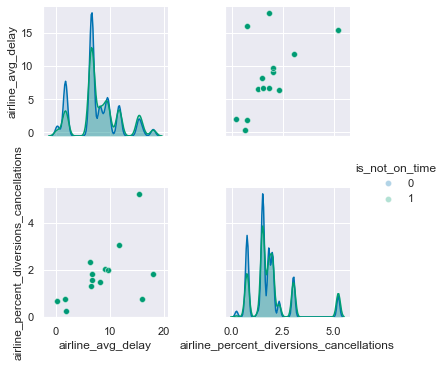

In [72]:
pairplot_features(sample_df[numerical_features + target])

In [84]:
y.head()

,is_not_on_time
0,0
1,0
2,1
3,0
4,0


In [149]:
X, y = feature_target_selection(all_features, target, sample_df)

In [150]:
X_train_val, X_test, y_train_val, y_test = initial_split(X, y.values.ravel())
X_train, X_val, y_train, y_val = second_split(X_train_val, y_train_val)

In [151]:
lm = LogisticRegression(penalty='none', max_iter=10000)
lm.fit(X_train_val, y_train_val)

LogisticRegression(max_iter=10000, penalty='none')

In [152]:
cv(lm, X_train_val, y_train_val, cv_records)

/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/binhhoang/opt/anaconda3/envs/m

Model name: LogisticRegression
Hyperparameters: max_iter=10000, penalty='none'

Mean train F1:             0.00
Mean val F1:               0.00
Mean train precision:      0.00
Mean val precision:        0.00
Mean train recall:         0.00
Mean val recall:           0.00
Mean train accuracy:       0.83
Mean val accuracy:         0.83
Mean train AUC:            0.57
Mean val AUC:              0.57
iteration_desc: 
feature_engineering: removed airline_percent_diversions_cancellations due to potential multi-collinearity


In [142]:
del cv_records[-1]

In [155]:
cv_records

[{'model': 'logistic',
  'iteration_desc': 'baseline',
  'feature_engineering': '',
  'hyperparameter_tuning': '',
  'mean_train_f1': 0.0,
  'mean_val_f1': 0.0,
  'mean_train_precision': 0.0,
  'mean_val_precision': 0.0,
  'mean_train_recall': 0.0,
  'mean_val_recall': 0.0,
  'mean_train_accuracy': 0.8326874999999999,
  'mean_val_accuracy': 0.8326875000000001},
 {'model': 'logistic',
  'iteration_desc': '2nd baseline',
  'feature_engineering': 'airline_avg_delay, airline_percent_diversions_cancellations',
  'hyperparameter_tuning': '',
  'mean_train_f1': 0.0,
  'mean_val_f1': 0.0,
  'mean_train_precision': 0.0,
  'mean_val_precision': 0.0,
  'mean_train_recall': 0.0,
  'mean_val_recall': 0.0,
  'mean_train_accuracy': 0.8335250000000001,
  'mean_val_accuracy': 0.8335250000000001},
 {'model': 'logistic',
  'iteration_desc': 'iterating on baseline by adding airline dummy variables',
  'feature_engineering': 'added airline dummy variables',
  'hyperparameter_tuning': '',
  'mean_train_f1':

In [94]:
def print_model_coef(X, model):
    for feature, coef in zip(X.columns, model.coef_[0]):
        print(f'{feature: <40} {coef:.2f}')

In [154]:
print_model_coef(X_train_val, lm)

airline_avg_delay                        0.07
American Airlines Inc.                   0.08
American Eagle Airlines Inc.             -0.09
Atlantic Southeast Airlines              -0.05
Delta Air Lines Inc.                     -0.00
Frontier Airlines Inc.                   0.01
Hawaiian Airlines Inc.                   -0.42
JetBlue Airways                          0.13
Skywest Airlines Inc.                    -0.03
Southwest Airlines Co.                   0.10
Spirit Air Lines                         -0.01
US Airways Inc.                          0.01
United Air Lines Inc.                    0.19
Virgin America                           -0.05


In [156]:
lm.predict_proba(X_train)

array([[0.83615889, 0.16384111],
       [0.88638159, 0.11361841],
       [0.8959159 , 0.1040841 ],
       ...,
       [0.88638159, 0.11361841],
       [0.8082016 , 0.1917984 ],
       [0.83615889, 0.16384111]])

(array([0.        , 0.01692474, 0.03054855, 0.07640139, 0.11937342,
        0.20801825, 0.30134438, 0.40247269, 0.62039371, 0.74708918,
        0.78135878, 0.79210179, 0.95582763, 0.98673629, 1.        ]),
 array([0.        , 0.0323547 , 0.05032954, 0.11623727, 0.16686639,
        0.27651288, 0.39724386, 0.50659077, 0.71509886, 0.83283403,
        0.86249251, 0.87237867, 0.97453565, 0.99580587, 1.        ]),
 array([1.27168273, 0.27168273, 0.26363966, 0.22550872, 0.19227518,
        0.18951468, 0.18533898, 0.1725599 , 0.16487389, 0.16265738,
        0.15039799, 0.14037701, 0.11444392, 0.09841949, 0.08327915]))

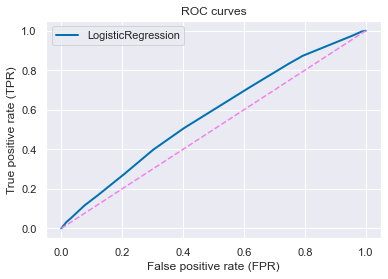

In [157]:
plot_ROC(lm, X_train, X_val, y_train, y_val)